# Expectation Maximization
#### by Alvin Zhang
##### Notes and examples based on Bishop's "Pattern Recognition and Machine Learning"

The expectation maximization (EM) algorithm helps us find ML and MAP solutions for models with latent variables. Suppose the observations are denoted $\mathbf{X}$ and the latent variables are denoted as $\mathbf{Z}$. Further, suppose that the model has parameters $\vec{\theta}$. Our goal is to maximize $p(\mathbf{X}|\vec{\theta})$ w.r.t. $\vec{\theta}$. We assume that this likelihood function is difficult to optimize analytically, while the complete-data (having both $\{\mathbf{X}, \mathbf{Z}\}$) likelihood function $p(\mathbf{X}, \mathbf{Z}|\vec{\theta})$ is easy to optimize. <br> <br>
After initializing the parameters, the first step is to evaluate the posterior distribution of the latent variables $$p(\mathbf{Z}|\mathbf{X},\vec{\theta}^{\text{old}})$$ (which is typically done using Bayes' theorem) since we'll need this value in the expected value of the log likelihood, which is given by $$Q(\vec{\theta}, \vec{\theta}^{\text{old}})=\sum_{\mathbf{Z}}p(\mathbf{Z}|\mathbf{X},\vec{\theta}^{\text{old}})\log{p(\mathbf{X}, \mathbf{Z}|\vec{\theta})}$$ (for discrete $\mathbf{Z}$; replace summation with an integral if $\mathbf{Z}$ is continuous). <br>
Since we've already evaluated the posterior of $\mathbf{Z}$ and we know that the joint distribution is optimized easily, we can set the new parameters as $$\vec{\theta}^{\text{new}}=\text{argmax}_{\vec{\theta}}Q(\vec{\theta}, \vec{\theta}^{\text{old}})$$ We then repeat evaluating the posterior (with the new parameters) and re-optimizing the hyperparameters until we reach some convergence criterion.

## k-means clustering

The k-means algorithm is strikingly similar to the EM algorithm. The main difference is that in k-means clustering, we use a "hard assignment", where each datapoint is assigned 100% to one cluster. EM, on the other hand, makes a "soft assignment" with responsibilities based off the posterior. We'll see this in the next section when we look at Gaussian Mixture Models. The k-means algorithm is relatively simple; the model is governed by the parameter $\vec{\mu}$, where $\mu_k$ is the mean of each cluster. $\vec{r}$ is the vector that contains class assignment; $r_n$ denotes which class $\mathbf{X}_n$ is assigned to. The algorithm can be broken into the following iterative procedure: <br>
$\qquad$ 1. Initialize the means $\vec{\mu}$ <br>
$\qquad$ 2. Assign each point $\mathbf{X}_n$ to the closest cluster mean (usually using Euclidean distance) and store the cluster $k$ into $r_n$ <br>
$\qquad$ 3. For each cluster, set $\vec{\mu}_k$ to the mean of all the points assigned to that cluster. <br>
$\qquad$ 4. Repeat 2 and 3 until convergence (when there is no change in assignments) <br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class K_means:
    def __init__(self, X, K):
        """
        Initializes K-means object.
        Args:
            X (float ndarray): data points
            K (int): number of clusters
        """
        self.X = X
        self.N, self.D = self.X.shape
        self.K = K
        self.r = np.zeros(self.N)
        unique_values = np.unique(self.X, axis=0)
        # random initialization
        self.means = unique_values[np.random.permutation(unique_values.shape[0])[0:self.K], :]

    def fit(self, plot=True, maxiter=float('inf')):
        """
        Fits K-means object.
        Args:
            plot (bool): whether to plot each step for 2D datasets
            maxiter (int): maximum number of iterations
        Returns:
            means_and_covs (dictionary): dictionary that maps a class to a list containing its mean and covariance
            r (int ndarray): classes corresponding to X
        """
        changed = True
        num_iter = 0
        while changed and num_iter < maxiter:
            num_iter += 1
            # Expectation
            changed = False
            for n in range(self.N):
                new_r = np.argmin([np.linalg.norm(self.X[n] - mean)**2 for mean in self.means])
                if self.r[n] != new_r:
                    self.r[n] = new_r
                    changed = True
            # Maximization
            counter = {k:[0, 0] for k in range(self.K)}
            for n in range(self.N):
                k = self.r[n]
                counter[k][0] += self.X[n]
                counter[k][1] += 1
            for k in range(self.K):
                self.means[k] = counter[k][0] / counter[k][1]
            # Plot
            if plot:
                colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
                for k in range(self.K):
                    points = X[np.where(self.r==k)[0]]
                    plt.plot(points[:, [0]], points[:, [1]], colors[k] + 'o')
                    plt.plot(self.means[k, [0]], self.means[k, [1]], colors[k] + 'x', markersize='15')
                plt.show()
        # Means and covariances
        means_and_covs = {k:[0, 0] for k in range(self.K)}
        for k in range(self.K):
            points = self.X[np.where(self.r==k)[0]]
            means_and_covs[k][0] = self.means[k]
            means_and_covs[k][1] = np.average((points - self.means[k]) ** 2)

        return means_and_covs, self.r

As an example, we'll try to cluster the following dataset into 3 clusters:

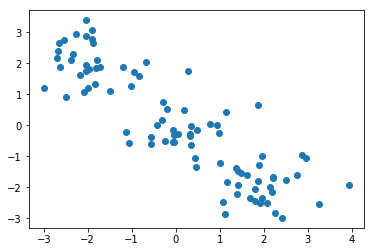

In [2]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2X.csv'
X = np.loadtxt(file_name_X, delimiter=',')

plt.plot(X[:, [0]], X[:, [1]], 'o')
plt.show()

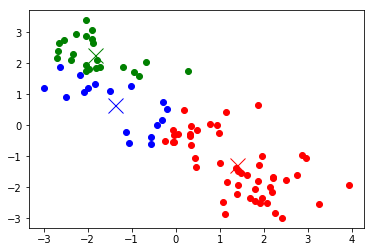

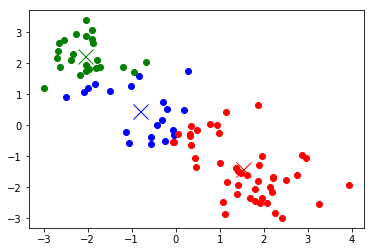

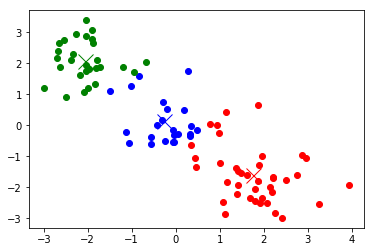

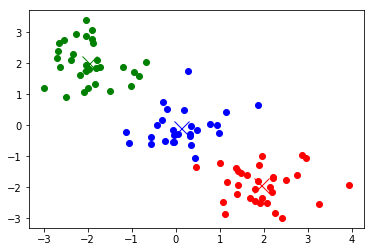

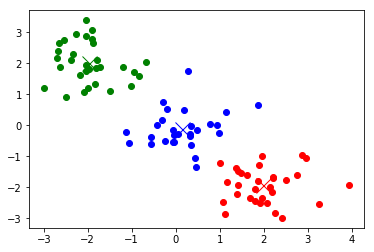

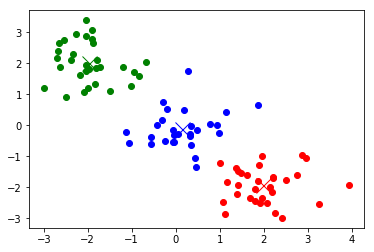

In [3]:
kmeans = K_means(X, 3)
_ = kmeans.fit(plot=True)

A useful application of k-means is data compression. We can compress images so that it only contains $K$ colors. Note that this is "lossy data compression", since we can't reconstruct the original from the comrpessed version. Suppose we have the following image:

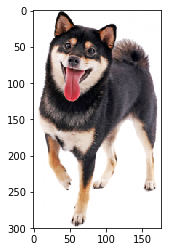

In [4]:
import matplotlib.image as mpimg
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\dog.png'
X = mpimg.imread(file_name_X)[:, :, 0:3].reshape(300*176, 3)

plt.imshow(X.reshape(300, 176, 3))
plt.show()

Suppose we want to reduce this image to 5 colors. After running k-means, we just assign each datapoint to its mean. This results in:

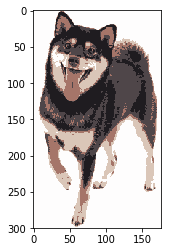

In [5]:
kmeans = K_means(X, 5)
means_and_covs, r = kmeans.fit(plot=False, maxiter=100)

X_nearest = np.zeros(X.shape)
for n in range(X.shape[0]):
    X_nearest[n] = means_and_covs[r[n]][0]

plt.imshow(X_nearest.reshape(300, 176, 3))
plt.show()

Here it is with just two colors.

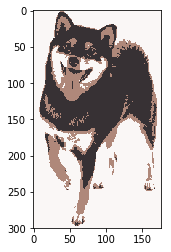

In [6]:
kmeans = K_means(X, 3)
means_and_covs, r = kmeans.fit(plot=False, maxiter=100)

X_nearest = np.zeros(X.shape)
for n in range(X.shape[0]):
    X_nearest[n] = means_and_covs[r[n]][0]

plt.imshow(X_nearest.reshape(300, 176, 3))
plt.show()

## Gaussian Mixture Models

Recall that we saw Gaussian Mixture Models in the probabilistic generative models section of the classification notebook. GMMs are given in the form $$p(\vec{x})=\sum_{k=1}^K\pi_k\mathcal{N}(\vec{x}|\vec{\mu}_k,\Sigma_k)$$
Let's derive this using latent variables. For an $\vec{x}$, introduce a latent variable $\vec{z}$ with a 1-of-K coding scheme such that $p(z_k=1)=\pi_k$, where the sum of $\vec{\pi}$ is 1 and $0\leq\pi_k\leq1$. This can be rewritten as
$$p(\vec{z})=\prod_{k=1}^K\pi_k^{z_k}$$
The conditional distribution given $\vec{z}$ is
$$p(\vec{x}|\vec{z})=\prod_{k=1}^K\mathcal{N}(\vec{x}|\vec{\mu}_k,\Sigma_k)^{z_k}$$
Hence,
$$p(\vec{x})=\sum_\vec{z}p(\vec{x}, \vec{z})=\sum_\vec{z}p(\vec{z})p(\vec{x}|\vec{z})=\sum_{k=1}^K\pi_k\mathcal{N}(\vec{x}|\mu_k, \Sigma_k)$$
Note that we can also calculate the posterior $p(\vec{z}|\vec{x})$ using Bayes' theorem; this distribution will be essential in training the GMM. 
$$p(\vec{z}|\vec{x},\vec{\mu},\Sigma, \vec{\pi})\propto\prod_{k=1}^K[\pi_k\mathcal{N}(\vec{x}_n|\vec{\mu}_k, \Sigma_k)]^{z_{nk}}$$
We will introduce the "responsibility" $\gamma(z_{nk})$ as the expected value of $z_{nk}$.
$$\gamma(z_{nk})=\mathbb{E}[z_{nk}] = \frac{\sum_{z_{nk}}z_{nk}[\pi_k\mathcal{N}(\vec{x}_n|\vec{\mu}_k,\Sigma_k)]^{z_{nk}}}{\sum_{z_{nk}}[\pi_j\mathcal{N}(\vec{x}_n|\vec{\mu_j},\Sigma_j)]^{z_{nj}}} =\frac{\pi_k\mathcal{N}(\vec{x}|\vec{\mu}_k,\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal{N}(\vec{x}|\vec{\mu}_j,\Sigma_j)}$$ <br><br>
Now suppose we have a $N\times D$ dataset $\mathbf{X} = \{\vec{x}_1,...,\vec{x}_N\}$. We introduce the corresponding latent variables with the $N\times K$ matrix $\mathbf{Z}$. The log likelihood is given by
$$\log{p(\mathbf{X}|\vec{\pi}, \vec{\mu}, \Sigma)}=\sum_{n=1}^N\log{\left(\sum_{k=1}^K\pi_k\mathcal{N}(\vec{x}_n|\vec{\mu}_k,\Sigma_k)\right)}$$
The expected [complete-data] log likelihood function is given by
$$\mathbb{E}_{\mathbf{Z}}[\log{p(\mathbf{X},\mathbf{Z}|\vec{\mu}, \Sigma, 
\vec{\pi})}]=\sum_{n=1}^N\sum_{k=1}^K\gamma(z_{nk})\left(\log{\pi_k}+\log{\mathcal{N}(\vec{x}_n|\vec{\mu}_k,\Sigma_k)}\right)$$
Deriving (hold $\gamma(z_{nk})$ constant): <br>
$\qquad$w.r.t. $\vec{\mu}_k$: $0=-\sum_{n=1}^N\gamma(z_{nk})\Sigma_k^{-1}(\vec{x}_n-\vec{\mu}_k) \Rightarrow 0=-\sum_{n=1}^N\gamma(z_{nk})(\vec{x}_n-\vec{\mu}_k) \Rightarrow \vec{\mu}_k=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})\vec{x}_n$ <br> $\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad$where $N_k=\sum_{n=1}^N\gamma(z_{nk})$ (effective number of points assigned to $k$) <br>
$\qquad$w.r.t. $\Sigma_k$: $\Sigma_k=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(\vec{x}_n-\vec{\mu}_k)(\vec{x}_n-\vec{\mu}_k)^T$ <br>
$\qquad$w.r.t. $\pi_k$: $\pi_k=\frac{N_k}{N}$ <br>
Hence, we use these formulas in the M-step of the EM algorithm.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mv_gauss


class GMM:
    def __init__(self, X, K):
        """
        Initializes Gaussian Mixture Model.
        Args:
            X (float ndarray): data points
            K (int): number of clusters
        """
        self.X = X
        self.N, self.D = self.X.shape
        self.K = K
        unique_values = np.unique(self.X, axis=0)
        # random initialization
        self.means = unique_values[np.random.permutation(unique_values.shape[0])[0:self.K], :]
        self.covs = [np.eye(self.D) for _ in range(self.K)]
        self.mix_coeff = np.abs(np.random.randn(self.K, 1))
        self.mix_coeff /= sum(self.mix_coeff)

    def fit(self, plot=True, maxiter=200):
        """
        Fits Gaussian Mixture Model.
        Args:
            plot (bool): whether to plot each step for 2D datasets
            maxiter (int): maximum number of iterations
        Returns:
            means (float ndarray): means of each cluster
            covs (float ndarray list): covariance of each cluster
            mix_coeff (float ndarray): mixing coefficients
        """
        gamma = np.zeros((self.N, self.K))
        for _ in range(maxiter):
            # Expectation
            for n in range(self.N):
                for k in range(self.K):
                    gamma[n, k] = self.mix_coeff[k] * \
                                  mv_gauss(self.means[k], self.covs[k]).pdf(self.X[n])
            gamma /= np.sum(gamma, axis=1).reshape(-1, 1)
            # Maximization
            for k in range(self.K):
                N_k = np.sum(gamma[:, [k]])
                # Means
                self.means[k] = 1/N_k * np.sum(gamma[:, [k]] * X, axis=0)
                # Covariances
                self.covs[k] = 1/N_k * np.sum(gamma[n, k] *
                                              (X[n]-self.means[k]).reshape(-1, 1).dot((X[n]-self.means[k]).reshape(1, -1))
                                              for n in range(self.N))
                # Mixing coefficients
                self.mix_coeff[k] = N_k / self.N
        # Plot
        if plot:
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
            for k in range(self.K):
                points = X[np.where(np.argmax(gamma, axis=1) == k)[0]]
                plt.plot(points[:, [0]], points[:, [1]], colors[k] + 'o')
                plt.plot(self.means[k, [0]], self.means[k, [1]], colors[k] + 'x', markersize='15')
            plt.show()
        return self.means, self.covs, self.mix_coeff


Suppose we have the following synthetically generated dataset, which is made of three multivariate Gaussians.

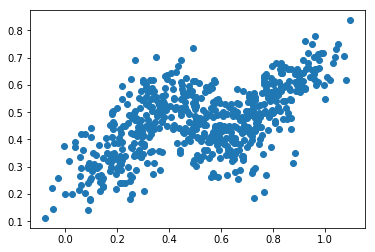

In [8]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set6X.csv'
X = np.loadtxt(file_name_X, delimiter=',')

plt.plot(X[:, [0]], X[:, [1]], 'o')
plt.show()

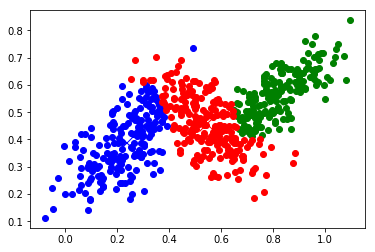

In [9]:
gmm = GMM(X, 3)
_ = gmm.fit()

Typically, we initialize the means and covariances by using k-means clustering.

## EM Algorithm Proof

Here, we'll go over a quick proof that the EM algorithm actually works. Recall that our goal is to maximize the likelihood function
$$ p(\mathbf{X}|\vec{\theta})=\sum_{\mathbf{Z}}p(\mathbf{X},\mathbf{Z}|\vec{\theta})$$
Again, we assume optimizing $p(\mathbf{X}|\vec{\theta})$ is difficult while optimizing $p(\mathbf{X},\mathbf{Z}|\vec{\theta})$ is simple. We introduce a distribution $q(\mathbf{Z})$ for the latent variables. For any $q(\mathbf{Z})$, the following holds:
$$\log{p(\mathbf{X}|\vec{\theta})}=\mathcal{L}(q,\vec{\theta})+\text{KL}(q||p)$$
where $\mathcal{L}(q,\vec{\theta})=\sum_{\mathbf{Z}}q(\mathbf{Z})\log{\frac{p(\mathbf{X},\mathbf{Z}|\vec{\theta})}{q(\mathbf{Z})}}$ <br>
and $\text{KL}(q||p)=-\sum_{\mathbf{Z}}q(\mathbf{Z})\log{\frac{p(\mathbf{Z}|\mathbf{X},\vec{\theta})}{q(\mathbf{Z})}}$ is the Kullback-Leibler divergence between $q(\mathbf{Z})$ and the posterior $p(\mathbf{Z},\mathbf{X}|\vec{\theta})$
<br>since
$$\mathcal{L}(q,\vec{\theta}) + \text{KL}(q||p) = \sum_{\mathbf{Z}}q(\mathbf{Z})\left(\log{\frac{p(\mathbf{X},\mathbf{Z}|\vec{\theta})}{q(\mathbf{Z})}} -\log{\frac{p(\mathbf{Z}|\mathbf{X}, \vec{\theta})}{q(\mathbf{Z})}} \right) = \sum_{\mathbf{Z}}q(\mathbf{Z})\log{\frac{p(\mathbf{X},\mathbf{Z}|\vec{\theta})}{p(\mathbf{Z}|\mathbf{X},\vec{\theta})}}=
\sum_{\mathbf{Z}}q(\mathbf{Z})\log{p(\mathbf{X}|\vec{\theta})}=\log{p(\mathbf{X}|\vec{\theta})}\sum_{\mathbf{Z}}q(\mathbf{Z})
\qquad= \log{p(\mathbf{X}|\vec{\theta})}$$
In the E-step, the lower bound $\mathcal{L}(q,\vec{\theta})$ is maximized w.r.t. $q(\mathbf{Z})$ while holding $\vec{\theta}$ fixed. This is equivalent to minimizing the KL divergence between $q(\mathbf{Z})$ and $p(\mathbf{Z}|\mathbf{X},\vec{\theta})$ since $\log{p(\mathbf{X}|\vec{\theta)}}$ doesn't depend on $q(\mathbf{Z})$. Minimizing the KL divergence results in  $q(\mathbf{Z}) = p(\mathbf{Z}|\mathbf{X},\vec{\theta})$. This is why we calculate the posterior in the E-step. <br>
In the M-step, the lower bound $\mathcal{L}(q,\vec{\theta})$ is maximized w.r.t. $\vec{\theta}$ while holding $q(\mathbf{Z})$ fixed. This causes the lower bound to increase, which will consequently cause $\log{p(\mathbf{X}|\vec{\theta)}}$ to increase as well, since the log likelihood does depend on $\vec{\theta}$. Therefore, we have new parameters $vec{\theta}^{\text{new}}$; however, the distribution $q(\mathbf{Z})$ is not equal to the new posterior distribution $p(\mathbf{Z}|\mathbf{X},\vec{\theta}^{\text{new}})$, so we will have nonzero KL divergence. This proves after each E and M step, the parameters get closer resulting in the maximum log likelihood. <br>
Finally, note that the lower bound can be rewritten as
$$\mathcal{L}(q,\vec{\theta})=\sum_{\mathbf{Z}}p(\mathbf{Z}|\mathbf{X},\vec{\theta}^{\text{old}})\log p(\mathbf{X},\mathbf{Z}|\vec{\theta})-\sum_{\mathbf{Z}}p(\mathbf{Z}|\mathbf{X},\vec{\theta}^{\text{old}})\log{p(\mathbf{Z}|\mathbf{X},\vec{\theta}^{\text{old}})}=Q(\vec{\theta}, \vec{\theta}^{\text{old}}) + \text{const}$$
as seen in the introduction. <br>
Here are the visuals that are included in the textbook that explain this proof:
<img src="https://i.imgur.com/3G84puH.png">

TODO: EM for Bernoulli mixtures